In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC



%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5'] #,'4139266.3'] #,'4222175.0']
# morph_familiar = ['4222153.2','4222154.1','4222153.1','4222157.3','4222174.1','4222153.3']
morph_familiar = ['4222153.2','4222153.1','4222153.3','4222174.1']

In [4]:
mouse = '4222174.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1992,4222174.1,04_06_2019,1,TwoTower_foraging,80,1,CA1,2019-06-04,G:\My Drive\VR_Data\TwoTower\4222174.1\04_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\04_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\04_06_2...
2024,4222174.1,06_06_2019,2,TwoTower_foraging,91,1,CA1,2019-06-06,G:\My Drive\VR_Data\TwoTower\4222174.1\06_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\06_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\06_06_2...
2046,4222174.1,08_06_2019,2,TwoTower_foraging,67,1,CA1,2019-06-08,G:\My Drive\VR_Data\TwoTower\4222174.1\08_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\08_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\08_06_2...
2073,4222174.1,11_06_2019,2,TwoTower_foraging,64,1,CA1,2019-06-11,G:\My Drive\VR_Data\TwoTower\4222174.1\11_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\11_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\11_06_2...
2095,4222174.1,13_06_2019,2,TwoTower_foraging,66,1,CA1,2019-06-13,G:\My Drive\VR_Data\TwoTower\4222174.1\13_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\13_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\13_06_2...
2108,4222174.1,14_06_2019,2,TwoTower_foraging,70,1,CA1,2019-06-14,G:\My Drive\VR_Data\TwoTower\4222174.1\14_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\14_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\14_06_2...
2122,4222174.1,15_06_2019,3,TwoTower_foraging,71,1,CA1,2019-06-15,G:\My Drive\VR_Data\TwoTower\4222174.1\15_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\15_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\15_06_2...
2132,4222174.1,17_06_2019,2,TwoTower_foraging,58,1,CA1,2019-06-17,G:\My Drive\VR_Data\TwoTower\4222174.1\17_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\17_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\17_06_2...
2151,4222174.1,18_06_2019,2,TwoTower_foraging,67,1,,2019-06-18,G:\My Drive\VR_Data\TwoTower\4222174.1\18_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...


In [5]:
sess = df_mouse.iloc[-1]
print(sess)

MouseName                                                4222174.1
DateFolder                                              18_06_2019
SessionNumber                                                    2
Track                                            TwoTower_foraging
RewardCount                                                     67
Imaging                                                          1
ImagingRegion                                                     
DateTime                                       2019-06-18 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4222174.1\18_06_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...
Name: 2151, dtype: object


In [16]:
def sess_lar(sess,max_pos=450,cellmask = None):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


    effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
    #effMorph = (effMorph+.25)/1.5

    msort = np.argsort(effMorph)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    posmask = centers<=max_pos
    S_tm = S_trial_mat[:,posmask,:].reshape([S_trial_mat.shape[0],-1])
    S_tm_norm = S_tm/np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]
   # S_sm = np.matmul(S_tm_norm,S_tm_norm.T)


    lar = np.zeros(effMorph.shape)
    sim0 = np.zeros(effMorph.shape)
    sim1 = np.zeros(effMorph.shape)
    for trial in range(effMorph.shape[0]):
        mask0 = trial_info['morphs']==0
        mask1 = trial_info['morphs']==1
        if trial_info['morphs'][trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial]==1:
            mask1[trial]=False
            
        centroid0, centroid1 = np.nanmean(S_tm[mask0,:],axis=0), np.nanmean(S_tm[mask1,:],axis=0)
        centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
        centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
        
        sim0[trial],sim1[trial] = np.dot(S_tm_norm[trial,:],centroid0), np.dot(S_tm_norm[trial,:],centroid1) 
#         print(sim0,sim1)
        lar[trial]= np.log(np.dot(S_tm_norm[trial,:],centroid0)/np.dot(S_tm_norm[trial,:],centroid1))
    return lar, effMorph, sim0, sim1
        

    

In [17]:
lar,em,sim0,sim1 = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
31882 (31882,) (31882, 21) 91565
frame diff 0


(80,) (80,) (80,)


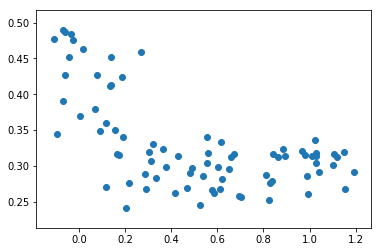

In [18]:
f,ax = plt.subplots()
print(lar.shape,sim0.shape,sim1.shape)
ax.scatter(em,sim0)

In [19]:
def LAR_list_maker(mlist,firstSess = None,max_pos=450.):
    LAR, EM,S0,S1 = {},{},{},{}
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mlist,firstSess): 
        LAR[mouse],EM[mouse],S0[mouse],S1[mouse] = [],[],[],[]
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
#             print(sess)
            lar, em,s0,s1 = sess_lar(sess,max_pos=max_pos)
            LAR[mouse].append(lar)
            EM[mouse].append(em)
            S0[mouse].append(s0)
            S1[mouse].append(s1)
    return LAR, EM,S0,S1

In [21]:
LAR_rare,EM_rare,S0_rare,S1_rare = LAR_list_maker(morph_rare)

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
frame diff 0
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
frame diff 0
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
frame diff 0
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
frame diff 0
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
frame diff 0
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
frame diff 0
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
frame diff 0
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
frame diff 0
session ind 9
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
frame diff 0
session ind 10
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0
session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
frame diff 0
sess

In [22]:
LAR_fam,EM_fam,S0_fam,S1_fam = LAR_list_maker(morph_familiar,firstSess=4)

session ind 4
num aberrant ttls 0.0
35248 (35248,) (35248, 21) 116195
frame diff 0
session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
frame diff 0
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
frame diff 0
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
frame diff 0
session ind 4
num aberrant ttls 0.0
36036 (36036,) (36036, 21) 118455
frame diff 0
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
frame diff 0
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
frame diff 0
session ind 4
num aberrant ttls 0.0
22769 (22769,) (22769, 21) 72892
frame diff 0
session ind 5
num aberrant ttls 0.0
13661 (13661,) (13661, 21) 44097
frame diff 0
session ind 4
num aberrant ttls 0.0
29526 (29526,) (29526, 21) 83238
frame diff 0
session ind 5
num aberrant ttls 0.0
34560 (34560,) (34560, 21) 97310
frame diff 0
session ind 6
num aberrant ttls 0.0
30879 (30879,) (30879, 21) 86531
frame diff 0
session i

In [56]:

def plot_LAR(LAR,EM,cmap='copper',ymin=-1.2,ymax=1.2):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR.keys())
    bins = np.linspace(-1,1)
    print(N)
    for i,mouse in enumerate(LAR.keys()):
        if len(LAR[mouse])>0:
            print(mouse)
            lar,em = np.concatenate(LAR[mouse]),np.concatenate(EM[mouse])
#             lar/=np.amax(lar)-np.amin(lar)
#             lar-=lar.mean()
#             lar/=np.amax(np.abs(lar))
            print(lar.shape)
            ax_scat.scatter(em,np.log(lar),color=cmap(np.float(i/N)),alpha=.4,s=8)
            hist,edges = np.histogram(lar,bins=bins)
            ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
            ax_hist.hist(lar,bins=50,orientation='horizontal',color=cmap(np.float(i/N)),alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)


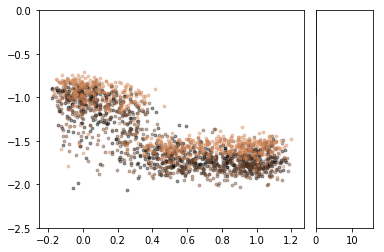

In [59]:
f,ax = plot_LAR(S0_rare,EM_rare,ymin=-2.5,ymax=0)
# f.savefig("G:\\My Drive\\07152019_dataupdate\\rare_sim0.pdf",format="pdf")
# f,ax = plot_LAR(S0_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
# f.savefig("G:\\My Drive\\07152019_dataupdate\\fam_sim0.pdf",format="pdf")

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4
4222153.2
(425,)
4222153.1
(281,)
4222153.3
(140,)
4222174.1
(400,)


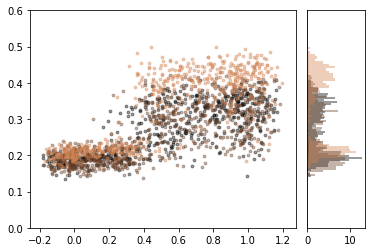

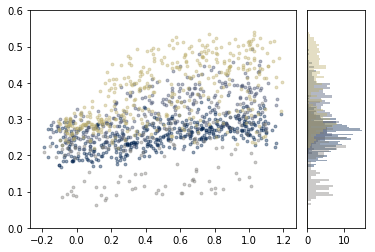

In [48]:
f,ax = plot_LAR(S1_rare,EM_rare,ymin=0,ymax=.6)
f.savefig("G:\\My Drive\\07152019_dataupdate\\rare_sim1.pdf",format="pdf")
f,ax = plot_LAR(S1_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
f.savefig("G:\\My Drive\\07152019_dataupdate\\fam_sim1.pdf",format="pdf")

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)


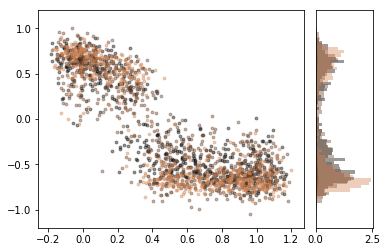

In [49]:
f,ax = plot_LAR(LAR_rare,EM_rare,cmap='copper')
f.savefig("G:\\My Drive\\07152019_dataupdate\\rare_simratio.pdf",format="pdf")
#f.savefig('morph_rare.svg',format='svg')

4
4222153.2
(425,)
4222153.1
(281,)
4222153.3
(140,)
4222174.1
(400,)


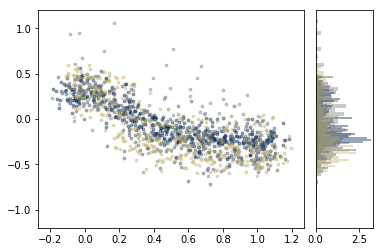

In [50]:
f,ax = plot_LAR(LAR_fam,EM_fam,cmap='cividis')
f.savefig("G:\\My Drive\\07152019_dataupdate\\fam_simratio.pdf",format="pdf")
#f.savefig('morph_fig.pdf',format='pdf')

1
4222174.1
(325,)


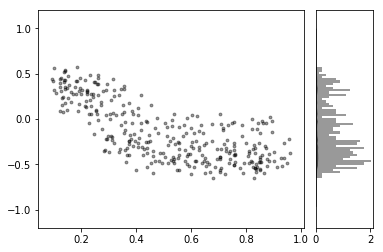

In [221]:
f,ax = plot_LAR(LAR_rd,EM_rd)
#f.savefig("rmd.svg",format='svg')

In [51]:
f,ax = plot_LAR(LAR_fd,EM_fd)
#f.savefig("fmd.svg",format="svg")

NameError: name 'LAR_fd' is not defined

In [33]:

def mega_lar(LAR,exclude=()):
    mega_lar =  []
    for k,v in LAR.items():
        if k not in exclude:
            mega_lar.extend(v)
    return np.concatenate(mega_lar)


mega_lar_fam = mega_lar(LAR_fam)
mega_lar_rare = mega_lar(LAR_rare)

mega_s0_fam = mega_lar(S0_fam)
mega_s1_fam = mega_lar(S1_fam)

mega_s0_rare = mega_lar(S0_rare)
mega_s1_rare = mega_lar(S1_rare)
#mega_lar_rd = mega_lar(LAR_rd)
#mega_lar_fd = mega_lar(LAR_fd)

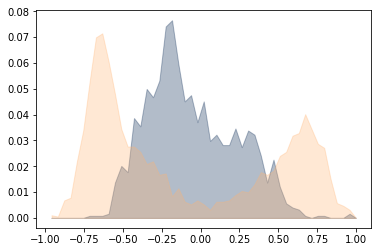

In [52]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
f.savefig("G:\\My Drive\\07152019_dataupdate\\lsr_hist.pdf",format="pdf")
# f.savefig('rare_fam_pdf.svg',format='svg')

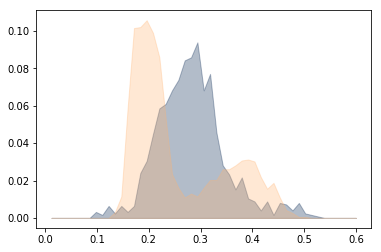

In [36]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s0_fam,bins)
rare_hist,edges = np.histogram(mega_s0_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

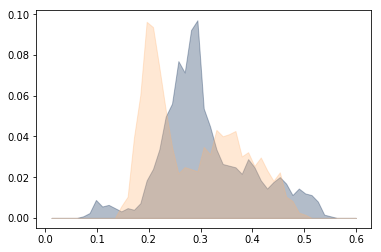

In [37]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s1_fam,bins)
rare_hist,edges = np.histogram(mega_s1_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

In [259]:
D,p = sp.stats.ks_2samp(mega_lar_rare,mega_lar_fam)
print(D,p)

0.3207254882289995 1.5038568678994995e-68


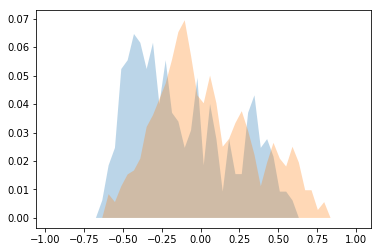

In [260]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
rd_hist,edges = np.histogram(mega_lar_rd,bins)
ax.fill_between(edges[1:],rd_hist/rd_hist.sum(),alpha=.3)
fd_hist,edges = np.histogram(np.concatenate(LAR_fd['4222157.4']),bins)
ax.fill_between(edges[1:],fd_hist/fd_hist.sum(),alpha=.3)

In [261]:
D,p = sp.stats.ks_2samp(mega_lar_rd,np.concatenate(LAR_fd['4222157.4']))

In [262]:
print(D,p)

0.2700854700854701 7.424574482520286e-15


In [263]:
def sarles_b(y):
    y = y.ravel()
    gamma = sp.stats.skew(y)
    kappa = sp.stats.kurtosis(y)
    n = y.shape[0] 
    
    alpha = 3*(n-1)**2/((n-2)*(n-3))
    
    return (gamma**2 +1)/(kappa + alpha)
    

In [264]:
b_fam = sarles_b(mega_lar_fam)
b_rare = sarles_b(mega_lar_rare)
print(b_fam,b_rare)
print(mega_lar_fam.mean(),mega_lar_rare.mean())

0.3218484286183123 0.7622330702664624
-0.1134732856430922 -0.11555465597390303


In [265]:
print(np.linalg.norm(mega_lar_fam,1)/mega_lar_fam.shape[0],np.linalg.norm(mega_lar_rare,1)/mega_lar_rare.shape[0])

0.2814740593215406 0.5554113282331284


shuffle control for the difference in average l1 distance from 0. shuffle which data points belong to which distribution
basically testing whether the mean of the distributions of absolute values are different

also look at value of lowest quartile of this distribution

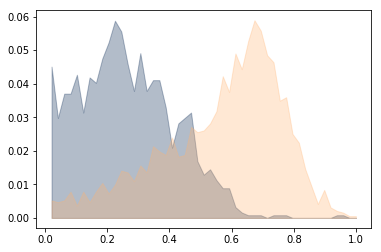

In [53]:
# plot distributions of absolute values and cdfs 
f,ax = plt.subplots()
bins = np.linspace(0,1)
fam_hist,edges = np.histogram(np.abs(mega_lar_fam),bins)
rare_hist,edges = np.histogram(np.abs(mega_lar_rare),bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

f.savefig("G:\\My Drive\\07152019_dataupdate\\abs_lsr_hist.pdf",format="pdf")

(49,)


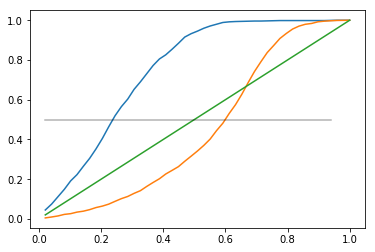

In [54]:
f,ax = plt.subplots()
print(fam_hist.shape)
fam_hist =fam_hist/fam_hist.sum()
rare_hist= rare_hist/rare_hist.sum()

ax.plot(bins[1:],np.cumsum(fam_hist))
ax.plot(bins[1:],np.cumsum(rare_hist))
ax.plot(bins[1:],bins[1:])
ax.plot(bins[1::5],.5*np.ones([10,]),alpha=.3,color='black')
f.savefig("G:\\My Drive\\07152019_dataupdate\\abs_lsr_cdf.pdf",format="pdf")

In [40]:
U,p = sp.stats.mannwhitneyu(np.abs(mega_lar_rare),np.abs(mega_lar_fam))
print(U,p)

298771.0 1.202174643981953e-279


In [41]:
# compare against null hypothesis of uniform distribution, median is shifted higher than uniform distribution
uniform_null = np.random.uniform(low=0,high=np.amax(np.abs(mega_lar_rare)),size=int(1E7))
U_u,p_u = sp.stats.mannwhitneyu(np.abs(mega_lar_rare),uniform_null)
print(U_u,p_u)

9025744411.0 2.820016782768889e-06


In [42]:
r_u = 1- 2*U_u/mega_lar_rare.shape[0]/1E7
print(r_u)
print(1-U_u/mega_lar_rare.shape[0]/1E7)

0.059818290520833206
0.5299091452604165


In [43]:
r = 1- 2*U/mega_lar_rare.shape[0]/mega_lar_fam.shape[0]
print(r)
print(1-U/mega_lar_rare.shape[0]/mega_lar_fam.shape[0])

0.7502248863028358
0.8751124431514179


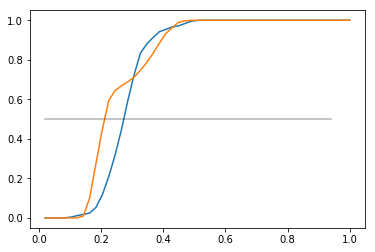

In [46]:
fam_hist,edges = np.histogram(mega_s0_fam,bins)
rare_hist,edges = np.histogram(mega_s0_rare,bins)

fam_hist =fam_hist/fam_hist.sum()
rare_hist= rare_hist/rare_hist.sum()

f,ax = plt.subplots()
ax.plot(bins[1:],np.cumsum(fam_hist))
ax.plot(bins[1:],np.cumsum(rare_hist))
ax.plot(bins[1::5],.5*np.ones([10,]),alpha=.3,color='black')